# ECE 5470 Lab 3 Report
## by Rufei Ye

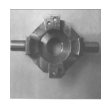

im1.vx
<scaled size: (512 x 512) >


In [3]:
import numpy as np
from v4 import vx
from v4 import vd

vd.dispmvx("mp.vx", size=0.3, capt="im1.vx")


### Section 2

Show, clearly labeled/captioned, the test images and the resulting images from the application of vtpeak.

    State (more than one sentence) your observations on each of the images tested in section 2 that indicate strengths and weaknesses of the Peakiness Algorithm.

Vtpeakpy is an automatic thresholding program. It assumes two major peaks and a single valley always exist and finds the lowest point between the two higheat peaks in the histogram. In the program, different distances(d) can be selected in order to help the algorithm find the correct peaks of the foreground and the background. Refering to the histogram is helpful when trying different "d" values.


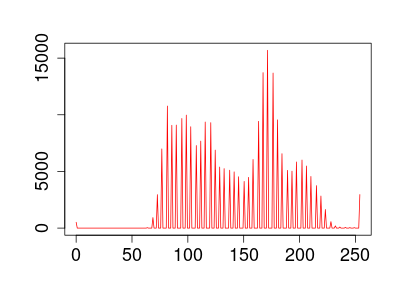

histogram of mp.vx


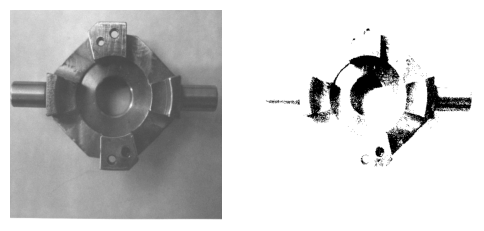

result of vtpeakpy on mp.vx with d=10
<scaled size: (512 x 512) (512 x 512) >


In [5]:
vd.dispvx('mph.png',capt='histogram of mp.vx')
vd.dispmvx('mp.vx','mpt.vx',size=0.75,  capt='result of vtpeakpy on mp.vx with d=10')

Using the '-v' in command vtpeakpy and applying the distance = 10, the outcome is that maxbin= 172 nxtbin= 82 and thresh= 83. According to the histogram of mp.vx, the highest peak region is located in  160~180, so choosing d = 10 is enough to seperate different peak regions. The output image can basically distinguish between the object and the background, but due to the effect of light shadows in the input image, it is hard to distinguish the entire region of the foreground peak. I also tried d=50, and it had the same outcome. When choosing d=100, the thresh changed and the output image became white.

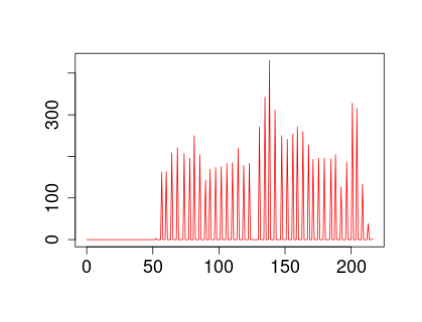

histogram of nb.vx
<scaled size: (300 x 400) >


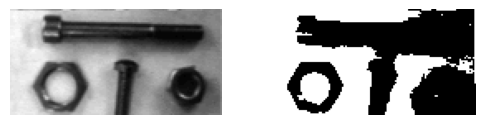

result of vtpeakpy on nb.vx with d=5
<scaled size: (64 x 128) (64 x 128) >


In [6]:
vd.dispmvx('nbh.png',capt='histogram of nb.vx')
vd.dispmvx('nb.vx','nbt.vx',size=0.75,  capt='result of vtpeakpy on nb.vx with d=5')

Using the '-v' in command vtpeakpy and applying the distance = 5, the outcome is that maxbin= 139 nxtbin= 201 thresh= 140. According to the histogram of nb.vx, the highest peak region is located in 135~145, so choosing d = 5 is enough to seperate different peak regions. The output image can basically distinguish between the object and the background. However, in the histogram, the object pixels are evenly distributed, so the threshold output image lost some details of the object.

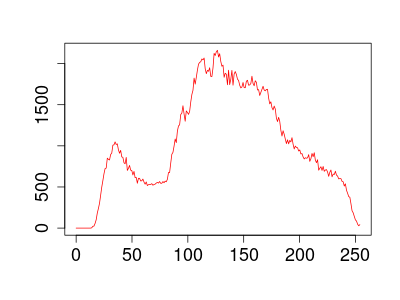

histogram of map


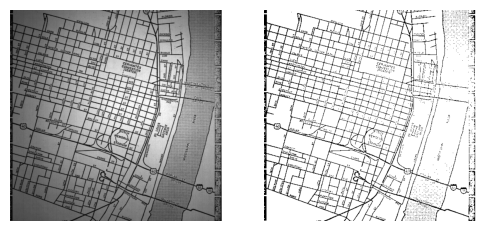

result of vtpeakpy on map with d=70
<scaled size: (512 x 512) (512 x 512) >


In [8]:
vd.dispvx('maph.png',capt='histogram of map')
vd.dispmvx('map','mapt.vx',size=0.75,  capt='result of vtpeakpy on map with d=70')

Using the '-v' in command vtpeakpy and applying the distance = 70, the outcome is that maxbin= 127 nxtbin= 35 thresh= 64. According to the histogram of map, the highest peak region is located in 80~200, so d=70 was chosen. The algorithm works particularly well on this image because there are two distinct peak regions in the histogram. I also tried d=50, the output thresh was 177 and there's a black circle around the image.

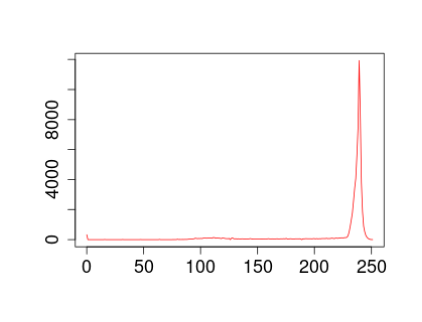

histogram of facsimile
<scaled size: (300 x 400) >


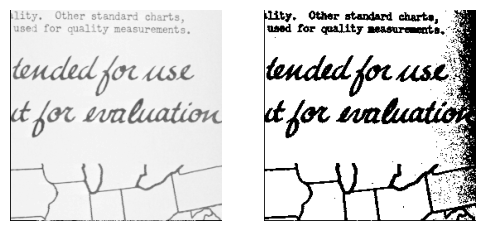

result of vtpeakpy on facsimile with d=5
<scaled size: (256 x 256) (256 x 256) >


In [10]:
vd.dispmvx('facsimileh.png',capt='histogram of facsimile')
vd.dispmvx('facsimile','facsimilet.vx',size=0.75,  capt='result of vtpeakpy on facsimile with d=5')

Using the '-v' in command vtpeakpy and applying the distance = 5, the outcome is that maxbin= 240 nxtbin= 235 thresh= 235. According to the histogram, the image only has one highest peak region. When d=10:maxbin= 240 nxtbin= 250 thresh= 250, the output image was whole black. When d=50:maxbin= 240 nxtbin= 0 thresh= 1, the output image was whole white. Theoretically, the distance parameter is used to avoid the highest peak region. However, due to the specificity of this pixel distribution, we cannot get the desired result if we avoid it completely.

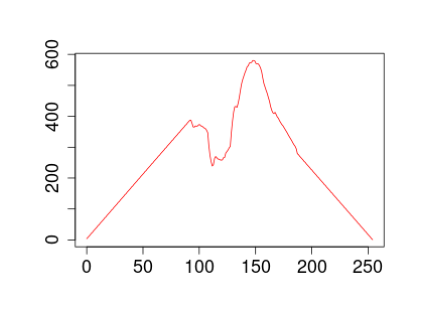

histogram of shtl.vx
<scaled size: (300 x 400) >


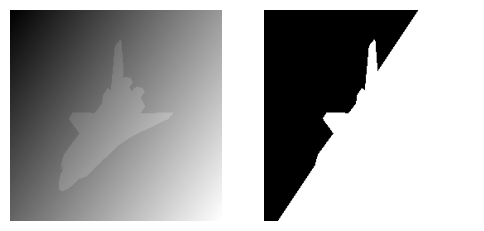

result of vtpeakpy on shtl.vx with d=50
<scaled size: (256 x 256) (256 x 256) >


In [11]:
vd.dispmvx('shtlh.png',capt='histogram of shtl.vx')
vd.dispmvx('shtl.vx','shtlt.vx',size=0.75,  capt='result of vtpeakpy on shtl.vx with d=50')

Using the '-v' in command vtpeakpy and applying the distance = 50, the outcome is that maxbin= 148 nxtbin= 93 thresh= 112. According to the histogram, it has two distinct peak regions where the algorithm seems to work effectively. However, in the output image, the algorithm did not seperate the foreground and the background well. This is because the input image of the shuttle object is a single gray color, but the background is a gradient color from black to white. When the threshold is determined, the algorithm outputs the result in such a way that the shuttle object is the same color as one side of the background.

### Section 3 Iterative Threshold Selection (vits)

#### 3.1 The vits program

In [4]:
#!/usr/bin/env python

"""
vits:  Iterative Threshold Selection Algorithm
"""

import numpy as np
from v4 import vx
import math

vargs = vx.vaparse("if= of= d= -v -")

if 'OPT' in locals():
   print ("vits: threshold between hgram peaks")
   print ("if= input file")
   print ("of= output file")
   print ("th= Get an initial threshold thresh")
   print ("-v  (verbose) print threshold information")
   exit(0)

optv = '-v' in vargs
for arg in ('if', 'of'):
     if arg not in vargs:
       print ( 'vits error: missing required parameter %s' % arg)
       exit(1)
inimage = vx.Vx(vargs['if'])
im = inimage.i
if im.dtype != 'uint8' :
    print ("error: image not byte type" )
    exit(1)

thresh = 0 #define thresh 
if 'th' in vargs: 
  thresh = int(vargs['th'])
  if thresh < 0 or thresh > 255:
      print("d= must be between 0 and 255" )
else:
#Compute the average gray value of image and use it as an initial threshold thresh
  total_pixel_value = 0
  count = 0
  for y in range(im.shape[0]):
      for x in range(im.shape[1]):
          total_pixel_value = total_pixel_value + im[y,x]
          count = count + 1
  thresh = total_pixel_value / count


# Create a blank histogram of 256 bins
hist = np.zeros(256)

# Compute the histogram
for y in range(im.shape[0]):
  for x in range(im.shape[1]):
    hist[im[y,x]]+=1
    
# Function to calculate average grey values
def average(a, b):
    avg = 0
    sum = 0
    count = 0
    for i in range(a,b):
        sum = sum + hist[i]*i
        count = count + hist[i]
    avg = sum /count
    return avg

avg1 = 0
avg2 = 0
old1 = 1
old2 = 1
count = 0

# Iterative to find the Threshold
while  avg1 != old1 and avg2 != old2:
# or count < 50
      old1 = avg1
      old2 = avg2      
      count = count +1 
      avg1 = average (0,math.ceil(thresh))
      avg2 = average (math.ceil(thresh),255)
      thresh = (avg1 + avg2)/2

# Print output for verbose mode
if (optv):
  print("thresh=",thresh )
  
# Apply threshold
for y in range(im.shape[0]):
  for x in range(im.shape[1]):
    if (im[y,x] >= thresh): 
      im[y,x] = 255
    else:
      im[y,x] = 0

inimage.write(vargs['of'])


#### 3.2 Program Discussion

Vits program implements an algorithm similar to the Iterative Threshold Selection Algorithm. Unlike the vtpeaky algorithm, it calculates average gray values and iterates to obtain the final threshold, rather than relying on the contours and distribution of the histogram alone. All image data are considered in determining threshold, so vits program is more robust and it's more likely to find the appropriate threshold. As a result, the output of some images has become better, and

However, when applying the threshold to the image, both of the two programs used the same method: values above thresh set to 255 otherwise 0. So in some images, the output is the same.

In the program, there is a count parameter that is used to prevent entering a dead loop, which was useful and necessary when debugging.

#### 3.3 Small image tests

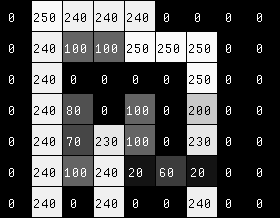

input: small.vx


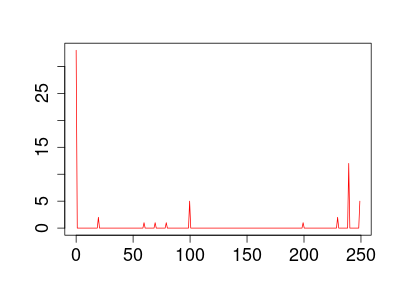

histogram of input: small.vx


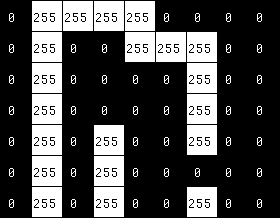

result of vits on small.vx


In [17]:
vd.dispvx('small.vx',capt='input: small.vx')
vd.dispvx('smallh.png',size=0.5,capt='histogram of input: small.vx')
vd.dispvx('small_vits.vx',size=0.75,  capt='result of vits on small.vx')

Using the '-v' in command vits, the outcome is that thresh= 128.47. The input image has different pixel values, icluding 20, 70, 80, 240, 250...The output image distinguishes between larger pixel values and smaller ones, which means the vits program works well. The pixels higher than 128 were reassigned to 255 and the rest pixels were assigned to 0.

#### 3.4 Large Imge tests

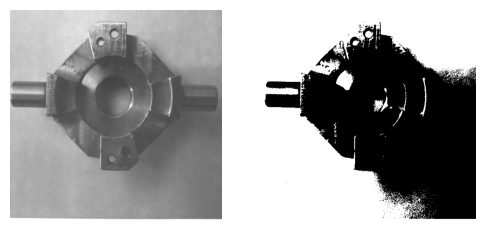

result of vits on mp.vx
<scaled size: (512 x 512) (512 x 512) >


In [18]:
vd.dispmvx('mp.vx','mp_vits.vx',size=0.75,  capt='result of vits on mp.vx')

Using the '-v' in command vits, the outcome is that thresh= 142.73, while the outcome of the vtpeakpy program is thresh= 83. The object in the image was distinguished from the background. However, the lower right part of the output image is also darkened, which is because the original image is not evenly lighted. In this figure, the vits algorithm performs better, but it is also not perfect.

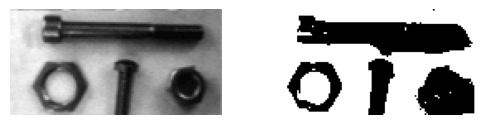

result of vits on mp.vx
<scaled size: (64 x 128) (64 x 128) >


In [19]:
vd.dispmvx('nb.vx','nb_vits.vx',size=0.75,  capt='result of vits on mp.vx')

Using the '-v' in command vits, the outcome is that thresh=128.25 , while the outcome of the vtpeakpy program is thresh=140 . The object in the image was distinguished well from the background. Compared with the output of the vtpeakpy program, the result of vits shows more details of the object's outline, which means that the threshold of vits algorithm is more effective in mp.vx.

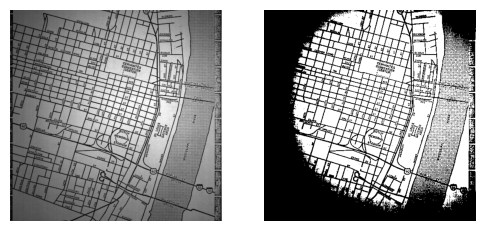

result of vits on map
<scaled size: (512 x 512) (512 x 512) >


In [21]:
vd.dispmvx('map','map_vits.vx',size=0.75,  capt='result of vits on map')

Using the '-v' in command vits, the outcome is that thresh=135.32 , while the outcome of the vtpeakpy program is thresh=64. Due to the uneven light distribution of the original image, there is a black circle around the output image. However, the vtpeakpy program worked well in this image.

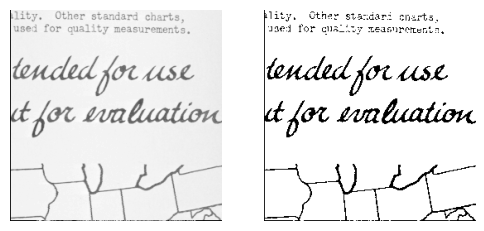

result of vits on facsimile
<scaled size: (256 x 256) (256 x 256) >


In [22]:
vd.dispmvx('facsimile','facsimile_vits.vx',size=0.75,  capt='result of vits on facsimile')

Using the '-v' in command vits, the outcome is that thresh=179.12 , while the outcome of the vtpeakpy program is thresh=235. The output image is well separated between foreground and background and is virtually without noise. In the vtpeakpy algorithm, because the histogram has only one peak region, it is different to derive a suitable threshold. However, the vits algorithm works well becauce it goes through iterative calculations and loops, rather than relying on the outline of the histogram.

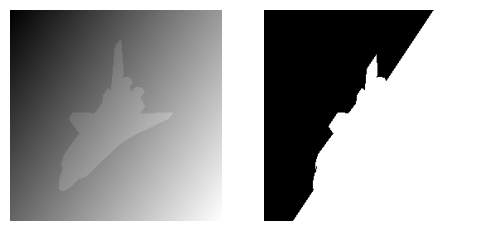

result of vits on shtl
<scaled size: (256 x 256) (256 x 256) >


In [23]:
vd.dispmvx('shtl.vx','shtl_vits.vx',size=0.75,  capt='result of vits on shtl')

Using the '-v' in command vits, the outcome is that thresh=122.46, while the outcome of the vtpeakpy program is thresh=112. However, the output image looks the same as the result of the vtpeakpy algorithm, because the threshold application algorithm in two programs is the same. The input image of the shuttle object is a single gray color, but the background is a gradient color from black to white. When the threshold is determined, the algorithm outputs the result in such a way that the shuttle object is the same color as one side of the background.

### 4.Region Growing (vgrow)

#### 4.1 The program vgrow

In [5]:
#!/usr/bin/env python

""" vgrow :a simple region growing algorithm based on the recursive connected component labeling algorithm developed in lab 2 called cclabel
"""

import numpy as np
from v4 import vx
import sys

of=' '
vxif=' '
vargs = vx.vaparse( "if= of= -v  - r= -p")
if '-' in vargs:
   print ("vgrow")
   print ("if= input file")
   print ("of= output file")
   print ("r= set the region pixel range.")
   print ("-p select the labeling scheme")
   print ("[-v] verbose mode")
   exit(0)

def setlabel (x, y, L):
    global im, tm
    im[y, x] = L
    
    if tm[y+1,x+2]> 0 and im[y, x+1]==0 :
        if abs(tm[y+1,x+2]- first) < rangeset:
            setlabel(x+1, y, L)
    if tm[y+1,x]> 0 and im[y, x-1]==0:
        if abs(tm[y+1,x]- first) < rangeset:
            setlabel(x-1, y, L)
    if tm[y+2,x+1]> 0 and im[y+1, x]==0:
        if abs(tm[y+2,x+1]- first) < rangeset:
            setlabel(x, y+1, L)
    if tm[y,x+1]> 0 and im[y-1, x]==0:
        if abs(tm[y,x+1]- first) < rangeset:
            setlabel(x, y-1, L)
            
# check arguments 
optv = '-v' in vargs
if 'if' in vargs:
   inimage = vx.Vx(vargs['if'])
else:
   print ( 'vgrow error: if= must be specified')
   exit()
im = inimage.i
if im.dtype != 'uint8' :
    print ('vgrow error: image not byte type', file=sys.stderr)
    exit(1)

#set range
rangeset = 10
if 'r' in vargs: 
  rangeset = int(vargs['r'])

#select the labeling scheme
global label_flag
label_flag = 0
if '-p' in vargs: 
    label_flag = 1
    print ('the label value will be the value of the first pixel in the region')


# check for output file name
if 'of' not in vargs:
   print ( 'vgrow error: of= must be specified')
   exit()

# Compute setlabel
tmimage = vx.Vx( inimage ) 
tmimage.embedim((1,1,1,1))
tm = tmimage.i

for y in range(im.shape[0] ):
    for x in range(im.shape[1]  ):
         im[y,x] = 0 
         #set all pixels to 0

L = 1    
sys.setrecursionlimit(100000)
global first
first = 0

if label_flag == 0 :  
    for y in range(im.shape[0]  ):
        for x in range(im.shape[1]  ):
            if tm[y+1,x+1]>0 and im[y,x]==0 :
                 first = int(tm[y+1,x+1])
                 setlabel(x,y,L)
                 L = L + 1 # increment
                 if L == 255: #reset to 1
                     L = 1
else:
    for y in range(im.shape[0]  ):
        for x in range(im.shape[1]  ):
            if tm[y+1,x+1]>0 and im[y,x]==0 :
                 first = int(tm[y+1,x+1])
                 setlabel(x,y,first)


if optv:
   print (im)

inimage.write(vargs['of'])


#### 4.2 Program Discussion

Vgrow program is an extension of the cclabel program in Lab2. They have the same computational logic, but vgrow algorithm adds two new features: (1)Identify all the connected pixels that are within a given range of values. (2)Add a new flag, "-p", to vgrow to select the labeling scheme. When this flag is set, the label value will be the value of the first pixel in the region. These two features make the vgrow algorithm more flexible in handling multi-pixel images, with better results than the cclabel algorithm.


When applying the vgrow program on a large full size image with a large regions, the program may run out of stack. To solve this problem when searching the suitable range, the code "sys.setrecursionlimit(100000)" is used to prevent the program from getting into infinite recursion.


#### 4.3 Small image tests

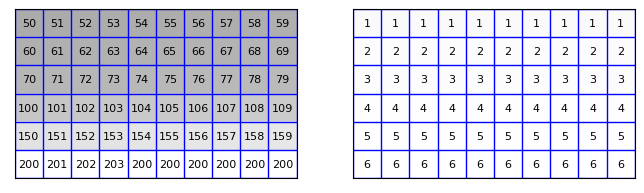

result 1 of vgrow on small test image, default range=10
<scaled size: (6 x 10) (6 x 10) >


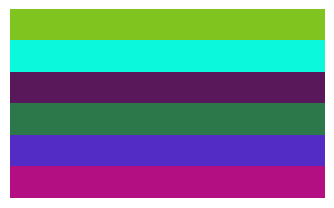

colorful result 1 of vgrow on small test image, default range=10
<scaled size: (6 x 10) >


In [33]:
vd.dispsvx('test_range.vx','test_range_vgrowr10.vx',size=1,  capt='result 1 of vgrow on small test image, default range=10')
vd.dispmvx('conew1.vx',size=1, capt='colorful result 1 of vgrow on small test image, default range=10')

The small test image will be used to test the vrgrow program in different ranges and in "-p" flag. The first result comes from the default range=10 without "-p" flag. Each line of the input image has a pixel range of 10 or less, and the colorful output image successfully divided the image into six lines. The "-p" flag is not used in the command, so the pixels in the output image are sorted in order starting with 1.

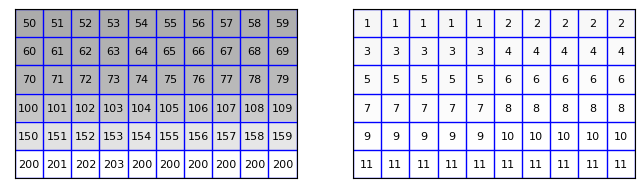

result 2 of vgrow on small test image,range=5
<scaled size: (6 x 10) (6 x 10) >


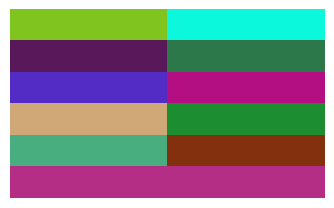

colorful result 2 of vgrow on small test image,range=5
<scaled size: (6 x 10) >


In [34]:
vd.dispsvx('test_range.vx','test_range_vgrowr5.vx',size=1,  capt='result 2 of vgrow on small test image,range=5')
vd.dispmvx('conew2.vx',size=1, capt='colorful result 2 of vgrow on small test image,range=5')

The second result comes from the predefined range=5 without "-p" flag. In the input image, the first five rows are independent of ten consecutive pixel values, and the last row includes the pixel values in the range of 5. After applying the vgrow program, as shown in the figure, the first five rows are separated and split in half within the rows as well, while the last row remains intact. As expected, the vgrow lgorithm works well.

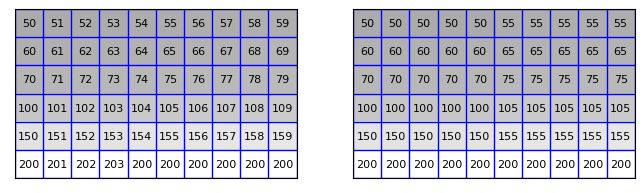

result 3 of vgrow on small test image,range=5,use p
<scaled size: (6 x 10) (6 x 10) >


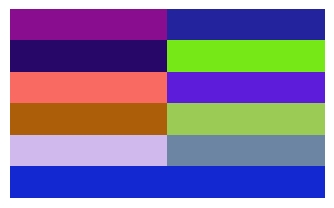

colorful result 3 of vgrow on small test image,range=5,use p
<scaled size: (6 x 10) >


In [35]:
vd.dispsvx('test_range.vx','test_range_vgrowr5p.vx',size=1,  capt='result 3 of vgrow on small test image,range=5,use p')
vd.dispmvx('conew3.vx',size=1, capt='colorful result 3 of vgrow on small test image,range=5,use p')

Based on the previous tests, the third test adds the "-p" flag. Because the range is still 5, the output color result is the same as the second test. In the normal output, the number of pixels at the beginning of each line is the same as the input image, which is also consistent with the design of the algorithm.

#### 4.4 Large Imge tests

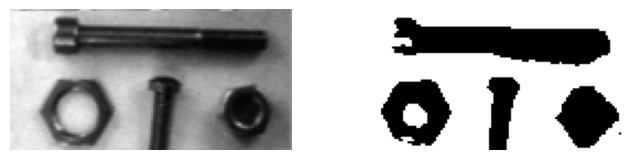

result of vgrow on nb.vx, range=87
<scaled size: (64 x 128) (64 x 128) >


In [38]:
vd.dispmvx('nb.vx','nb_vgrow.vx',size=1, capt='result of vgrow on nb.vx, range=87')

After several attempts, the range value used to seperate the foreground and background in nb.vx is 87. When the range is obtained small, the edges of the object are not clear enough and it will be divided into many gray levels. When the range is obtained larger, the image has more and more white parts, and some of the object itself is eliminated.

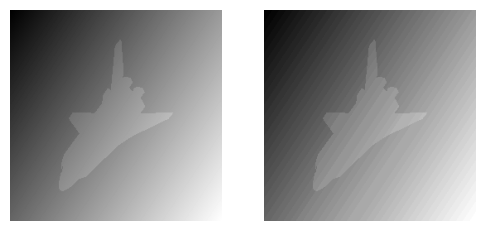

result of vgrow on shtl.vx, range=5
<scaled size: (256 x 256) (256 x 256) >


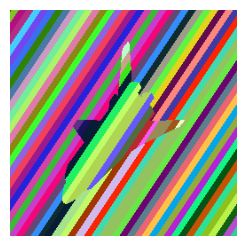

color result of vgrow on shtl.vx, range = 5
<scaled size: (256 x 256) >


In [49]:
vd.dispmvx('shtl.vx','shtl_vgrow.vx',size=0.75, capt='result of vgrow on shtl.vx, range=5')
vd.dispmvx('coshtl1.vx',size=0.75, capt='color result of vgrow on shtl.vx, range = 5')

Range = 5 is chosen to present the best result of the vgrow with "-p" flag. However, the output image is not good enough to define the outline of the shuttle. As the colorful output shows, the vgrow algorithm slices the image diagonally. the larger the range, the thicker the diagonal stripes, and the more fragmented the output image. As a result, the vgrow algorithm does not perform well on this image.

#### 4.5 Edge Image tests

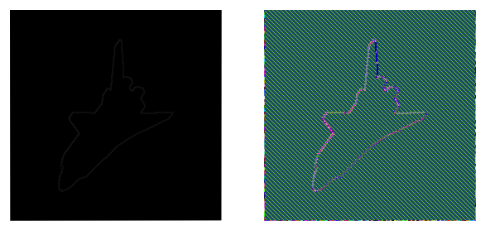

output of vsobel on shtl.vx & colorful output of vsobel on shtl.vx
<scaled size: (256 x 256) (256 x 256) >


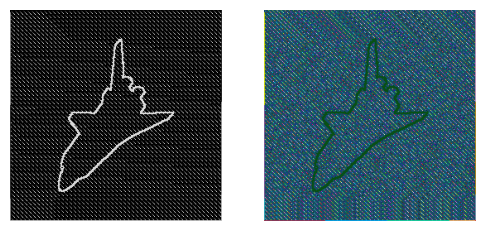

output of vgrow on edge.vx & colorful output of vgrow on edge.vx, range=30
<scaled size: (256 x 256) (256 x 256) >


In [57]:
vd.dispmvx('edge.vx','edge_colnew.vx',size=0.75,  capt='output of vsobel on shtl.vx & colorful output of vsobel on shtl.vx')
vd.dispmvx('edge_vgrow.vx','edge_conew.vx', size=0.75,  capt='output of vgrow on edge.vx & colorful output of vgrow on edge.vx, range=30')

First, aftering applying the command vsobel, the output image looks completely black, but in color index output we can see that shuttle's outline is detected. Next, with range=30, the vgrow algorithm does a good job of distinguishing and showing the outline of the shuttle. As a result, edge detection is an effective pre-processing method for vgrow. With the help of vsobel, shuttle's outline and background are distinguished and given different pixel values. And the vgrow algorithm makes the contours more clear. If the range setting is small, the output object outline will not be smooth enough.